# Sequence Classification using Recurrent Neural Networks(RNN)
In this homework, you will learn how to train a recurrent neural network for human action classification. RNN is designed handle sequential data. The network can incorporate both past history and current input. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a very good tutorial. You should read it before you start.

## Setup
Please make sure you have h5py and torchnet installed
> pip install h5py

> pip install git+https://github.com/pytorch/tnt.git@master


In [0]:
pip install h5py

In [0]:
pip install git+https://github.com/pytorch/tnt.git@master

  Cloning https://github.com/pytorch/tnt.git (to revision master) to /tmp/pip-req-build-s7tmyubs
  Running command git clone -q https://github.com/pytorch/tnt.git /tmp/pip-req-build-s7tmyubs
     |████████████████████████████████| 686kB 2.7MB/s 
     |████████████████████████████████| 204kB 45.2MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.5.1-cp36-none-any.whl size=30917 sha256=d0cafc9be64695b5ecd42b084600f9fdc7e89ce06c03f1b9e3377fe0eefa013d
  Stored in directory: /tmp/pip-ephem-wheel-cache-d71bkezo/wheels/17/05/ec/d05d051a225871af52bf504f5e8daf57704811b3c1850d0012
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655252 sha256=ddf4a59958a5cac06247f07ecd91611688432ec1fbb8104e1508a66934678d31
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=5175f2bf5f92d24319be9189517e65715865394971fe42023677a2ad355a46a

In [0]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt

use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor


use cuda: True


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd '/content/gdrive/My Drive/ML/hw6/temp/Question3/'

/content/gdrive/My Drive/ML/hw6/temp/Question3


## Dataset
The data we are using is skeleton data, which indicates the 3D locations of body joints. In total, there are 25 body joints. It is collected by Kinect v2. To make it easier, each sequence have same number of frames. You need to classify 10 different actions. There are 2000 training sequences, 400 validation sequences, and 500 test sequences. Each sequence has 15 frames, each frame is a 75-dimension vector (3*25). 

For your convenience, we provide the dataloader for you.


In [0]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, subset='train'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s_data.h5'%subset)
        self.subset = subset

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['data'])

        if subset != 'test':
            self.label_path = os.path.join(data_path, '%s_label.h5'%subset)
            with h5py.File(self.label_path) as f:
                self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        if self.subset != 'test':
            label = int(self.label[index])
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

trSet = Dataset('./data', subset='train')
valSet = Dataset('./data', subset='val')
tstSet = Dataset('./data', subset='test')

batch_size = 50
trLD = DD.DataLoader(trSet, batch_size=batch_size,
       sampler=DD.sampler.RandomSampler(trSet),
       num_workers=2, pin_memory=False)
valLD = DD.DataLoader(valSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(valSet),
       num_workers=1, pin_memory=False)
tstLD = DD.DataLoader(tstSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(tstSet),
       num_workers=1, pin_memory=False)

input_dim = trSet.n_dim
num_class = 10

In [0]:
trSet.data.shape

(2000, 15, 75)

## Model
Pytorch has implemented different types of recurrent layers for you. For this homework, you can use any type of RNNs as you want:
> torch.nn.RNN()

> torch.nn.LSTM()

> torch.nn.GRU()

You can check details for different types of recurrent layers here: [RNN](http://pytorch.org/docs/master/nn.html#torch.nn.RNN), [LSTM]( http://pytorch.org/docs/master/nn.html#torch.nn.LSTM), [GRU](http://pytorch.org/docs/master/nn.html#torch.nn.GRU)


### Implement a specific model
In this section, you need to implement a model for sequence classification. The model has following layers:
* A linear layer that can map features of 75-dimension to 100-dimension.
* 1 Layer LSTM layer with hidden size of 100
* A linear layer that goes from 100 to num_class (10). 

An LSTM layer takes an input of size of (batch_size, seq_len, fea_dim) and outputs a variable of shape (batch_size, seq_len, hidden_size). In this homework, the classification score for a sequence is the classification score for the last step of rnn_outputs.



In [0]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (10 points) ##############
        ###################################################
        self.project_layer = nn.Linear(75, 100)
        self.recurrent_layer = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)
        self.classify_layer = nn.Linear(100, 10)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(self.project_layer(input))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs[:, -1])
        return logits

model = SequenceClassify()
model.cuda()

SequenceClassify(
  (project_layer): Linear(in_features=75, out_features=100, bias=True)
  (recurrent_layer): LSTM(100, 100, batch_first=True)
  (classify_layer): Linear(in_features=100, out_features=10, bias=True)
)

## Train the model
After you have the dataloader and model, you can start training the model. Define a SGD optimizer with learning rate of 1e-3, and a cross-entropy loss function:

In [0]:
################ 2nd To Do  (5 points)##################
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().cuda()

In [0]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)


    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return acc.value()[0]

  


In [0]:
num_epochs = 100
evaluate_every_epoch = 10
for e in range(num_epochs):
    run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None) 

train Epoch: 0  , Loss: 2.3054,  Accuracy: 10.00
val Epoch: 0  , Loss: 2.3044,  Accuracy: 9.50
train Epoch: 1  , Loss: 2.3043,  Accuracy: 10.00
train Epoch: 2  , Loss: 2.3033,  Accuracy: 10.10
train Epoch: 3  , Loss: 2.3024,  Accuracy: 10.20
train Epoch: 4  , Loss: 2.3017,  Accuracy: 10.05
train Epoch: 5  , Loss: 2.3010,  Accuracy: 10.20
train Epoch: 6  , Loss: 2.3004,  Accuracy: 10.05
train Epoch: 7  , Loss: 2.2999,  Accuracy: 10.40
train Epoch: 8  , Loss: 2.2993,  Accuracy: 10.35
train Epoch: 9  , Loss: 2.2989,  Accuracy: 10.35
train Epoch: 10  , Loss: 2.2984,  Accuracy: 10.50
val Epoch: 10  , Loss: 2.2971,  Accuracy: 10.00
train Epoch: 11  , Loss: 2.2980,  Accuracy: 10.40
train Epoch: 12  , Loss: 2.2976,  Accuracy: 10.80
train Epoch: 13  , Loss: 2.2972,  Accuracy: 11.35
train Epoch: 14  , Loss: 2.2968,  Accuracy: 11.40
train Epoch: 15  , Loss: 2.2964,  Accuracy: 11.85
train Epoch: 16  , Loss: 2.2960,  Accuracy: 11.95
train Epoch: 17  , Loss: 2.2957,  Accuracy: 12.45
train Epoch: 18 

## Submit your results 

### Train a better model for action recognition!
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition validation set. 


### Testing the model and reporting the results
Test the model on the testing set and save the results as a .csv file. 
submit the results.csv file generated by predict_on_test(). Also mention the best performance on the Validation set, and submit the corresponding results csv file which results in the best performance. 
################ 3rd To Do  (15 points) ###############


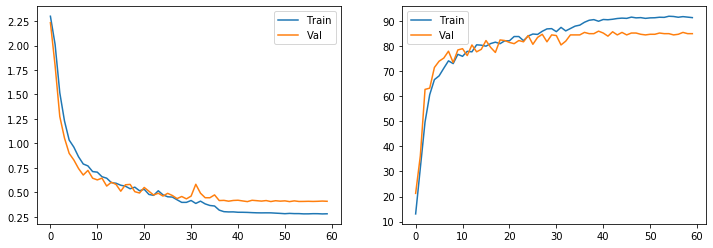

Epoch 59 => val_acc:  85.0


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        #print(output_logits.size())
        #print(output_logits)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)


    #print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return meter_loss.value()[0], acc.value()[0]
 
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
        
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=1, batch_first=True)
        self.classify_layer = nn.Sequential(
                                nn.Conv1d(15, 10, kernel_size=3),
                                nn.BatchNorm1d(10),
                                nn.LeakyReLU(),
                                Flatten(),
                                nn.Linear(1980, 10))
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs)
        return logits

model = SequenceClassify()

dtype = torch.cuda.FloatTensor
model = model.type(dtype)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True, min_lr=5e-5)
criterion = nn.CrossEntropyLoss().type(dtype)

train_loss = []
train_acc  = []
val_loss   = []
val_acc    = []
PATH = './saved_models/model_{}.pt'

best_acc = 50
num_epochs = 60
for e in range(num_epochs):
    loss, acc = run_epoch(trLD, model, criterion, e, True, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    
    loss, acc = run_epoch(valLD, model, criterion, e, False, None)
    val_loss.append(loss)
    val_acc.append(acc)
    scheduler.step(loss)
    if e > 1:
      clear_output(True)
      plt.figure(figsize=(12, 4))
      plt.subplot(121)
      plt.plot(train_loss)
      plt.plot(val_loss)
      plt.legend(['Train', 'Val'])
      plt.subplot(122)
      plt.plot(train_acc)
      plt.plot(val_acc)
      plt.legend(['Train', 'Val'])
      plt.show()
      print('Epoch', e, '=> val_acc: ', acc)
    name = str(acc)
    if best_acc < acc:
      best_acc = acc
      torch.save(model, PATH.format(name))

In [0]:
# Use your best model to generate results on test set and validation set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results_test_Q3.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count
    
model = torch.load(PATH.format(str(87.5)))
count=predict_on_test(model, tstLD)
print(count)

500


In [0]:
loss, acc = run_epoch(valLD, model, criterion, e, False, None)
acc

87.5

## Report the performance
################ 4th To Do  (5 points)##################

In this cell, you should write an explanation of what you did (network architecture, optimiziter, learning rate, epoches) and any visualizations or graphs that you make in the process of training and evaluating your network.



**best performance on the Validation set: 86.5**

**1) Default** Epoch 74 => val_acc:  61.5


```
Baseline model
```



In [0]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()

        self.project_layer = nn.Linear(75, 100)
        self.recurrent_layer = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)
        self.classify_layer = nn.Linear(100, 10)

    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(self.project_layer(input))

        logits = self.classify_layer(rnn_outputs[:, -1])
        return logits
model = SequenceClassify()
model

SequenceClassify(
  (project_layer): Linear(in_features=75, out_features=100, bias=True)
  (recurrent_layer): LSTM(100, 100, batch_first=True)
  (classify_layer): Linear(in_features=100, out_features=10, bias=True)
)

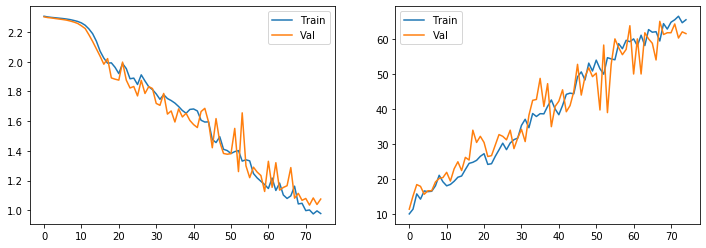

Epoch 74 => val_acc:  61.5


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 75


2) Epoch 75 => val_acc:  76.25


```
Increased trainable parameters in recurrent and classify layers,
Increased learning rate in SGD optimizer, added LR scheduler
```



In [0]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()

        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=300, num_layers=3, batch_first=True)
        self.classify_layer = nn.Linear(300, 10)

    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)

        logits = self.classify_layer(rnn_outputs[:, -1])
        return logits
model = SequenceClassify()
model

SequenceClassify(
  (recurrent_layer): LSTM(75, 300, num_layers=3, batch_first=True)
  (classify_layer): Linear(in_features=300, out_features=10, bias=True)
)

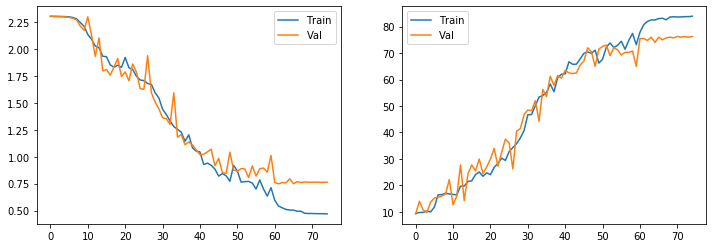

Epoch 75 => val_acc:  76.25


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 75


3) Epoch 75 => val_acc:  83.75


```
Reduced trainable parameters in recurrent layer and added conv1d layer in classify layer. Rest same.
```



In [0]:
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=1, batch_first=True)
        self.classify_layer = nn.Sequential(nn.Conv1d(15, 10, kernel_size=3),
                                            nn.BatchNorm1d(10),
                                            nn.ReLU(),
                                            Flatten(),
                                            nn.Linear(1980, 10))

    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs)
        return logits

model = SequenceClassify()
model

SequenceClassify(
  (recurrent_layer): LSTM(75, 200, batch_first=True)
  (classify_layer): Sequential(
    (0): Conv1d(15, 10, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Flatten()
    (4): Linear(in_features=1980, out_features=10, bias=True)
  )
)

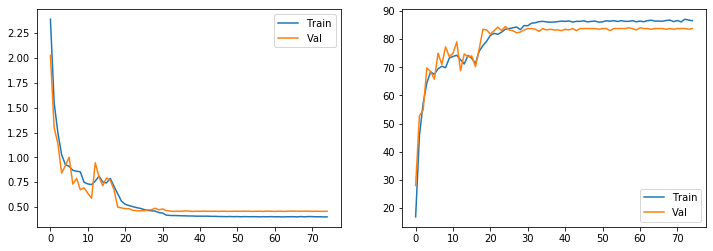

Epoch 75 => val_acc:  83.75


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 75


4) Epoch 75 => val_acc:  73.25


```
changed recurrent layer with dropout, bidirectional addition. Added one more lstm layer
```



In [0]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=2, dropout=0.8, bidirectional=True, batch_first=True)
        self.r2 = nn.LSTM(75, 50, num_layers=2, dropout=0.8, batch_first=True)
        self.classify_layer  = nn.Sequential(nn.Linear(450, 128),
                                             nn.BatchNorm1d(128),
                                             nn.LeakyReLU(),
                                             nn.Linear(128, 10))

    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        r2, (hn, cn) = self.r2(input)
        rnn_outputs = torch.cat((rnn_outputs, r2), 2)
        logits = self.classify_layer(rnn_outputs[:, -1])
        return logits

model = SequenceClassify()
model

SequenceClassify(
  (recurrent_layer): LSTM(75, 200, num_layers=2, batch_first=True, dropout=0.8, bidirectional=True)
  (r2): LSTM(75, 50, num_layers=2, batch_first=True, dropout=0.8)
  (classify_layer): Sequential(
    (0): Linear(in_features=450, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

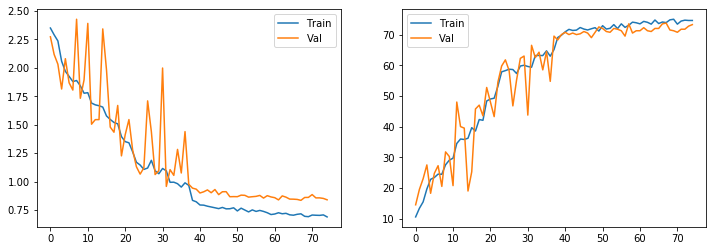

Epoch 75 => val_acc:  73.25


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 75

5) Epoch 29 => val_acc:  83.75


```
From 3rd attempt, increased 1 layer in LSTM, used LeakyReLU in classify layer, used Adam optimizer
```



In [0]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=2, batch_first=True)
        self.classify_layer = nn.Sequential(
                                nn.Conv1d(15, 10, kernel_size=3),
                                nn.BatchNorm1d(10),
                                nn.LeakyReLU(),
                                Flatten(),
                                nn.Linear(1980, 10))
        
    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs)
        return logits

model = SequenceClassify()
model

SequenceClassify(
  (recurrent_layer): LSTM(75, 200, num_layers=2, batch_first=True)
  (classify_layer): Sequential(
    (0): Conv1d(15, 10, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Flatten()
    (4): Linear(in_features=1980, out_features=10, bias=True)
  )
)

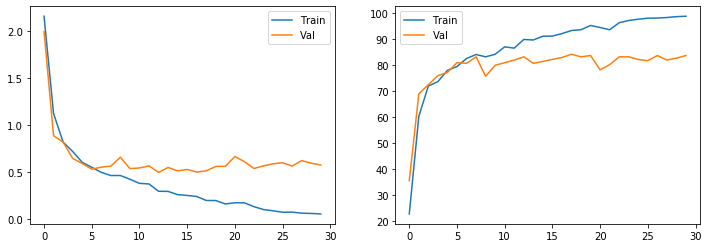

Epoch 29 => val_acc:  83.75


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 30

6) Epoch 75 => val_acc:  85.5


```
From last attempt, again kept 1 layer in recurrent layer, used SGD optimizer (both same as 3rd attempt)
```



In [0]:
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=1, batch_first=True)
        self.classify_layer = nn.Sequential(
                                nn.Conv1d(15, 10, kernel_size=3),
                                nn.BatchNorm1d(10),
                                nn.LeakyReLU(),
                                Flatten(),
                                nn.Linear(1980, 10))
    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs)
        return logits

model = SequenceClassify()
model

SequenceClassify(
  (recurrent_layer): LSTM(75, 200, batch_first=True)
  (classify_layer): Sequential(
    (0): Conv1d(15, 10, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Flatten()
    (4): Linear(in_features=1980, out_features=10, bias=True)
  )
)

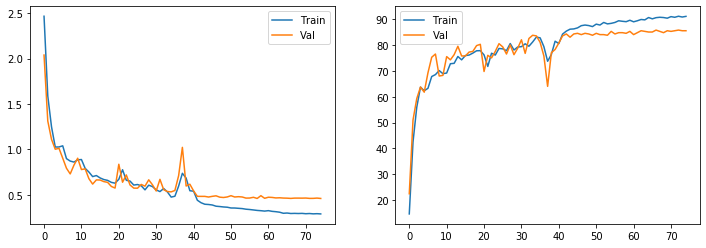

Epoch 75 => val_acc:  85.5


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 75

**Final** Epoch 99 => val_acc:  87.75 best: 87.75


```
Changed learning rate = 0.7*1e-3, added weight decay = 0.02. Rest same as previous.
```



In [0]:
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=1, batch_first=True)
        self.classify_layer = nn.Sequential(
                                nn.Conv1d(15, 10, kernel_size=3),
                                nn.BatchNorm1d(10),
                                nn.LeakyReLU(),
                                Flatten(),
                                nn.Linear(1980, 10))
    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs)
        return logits
        
model = SequenceClassify()
model

SequenceClassify(
  (recurrent_layer): LSTM(75, 200, batch_first=True)
  (classify_layer): Sequential(
    (0): Conv1d(15, 10, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Flatten()
    (4): Linear(in_features=1980, out_features=10, bias=True)
  )
)

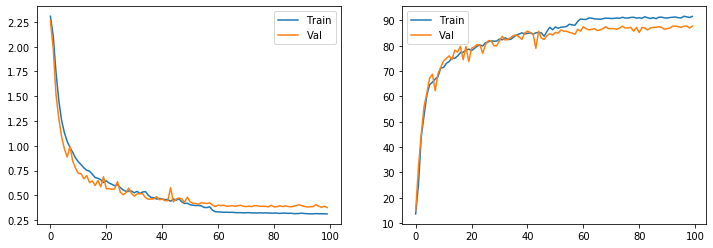

Epoch 99 => val_acc:  87.75 best: 87.75


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.7*1e-3, momentum=0.9, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True, min_lr=5e-5)
criterion = nn.CrossEntropyLoss().type(dtype)
num_epochs = 100

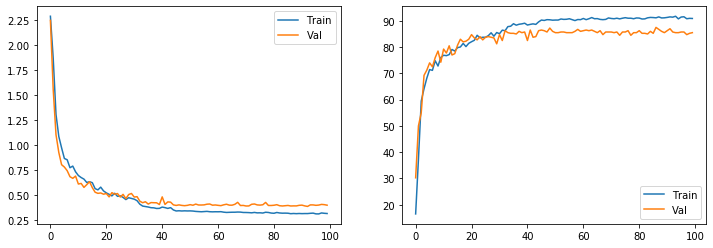

Epoch 99 => val_acc:  85.5 best: 87.5


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        #print(output_logits.size())
        #print(output_logits)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)


    #print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return meter_loss.value()[0], acc.value()[0]
 
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
        
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=1, batch_first=True)
        self.classify_layer = nn.Sequential(
                                nn.Conv1d(15, 10, kernel_size=3),
                                nn.BatchNorm1d(10),
                                nn.LeakyReLU(),
                                Flatten(),
                                nn.Linear(1980, 10))
    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs)
        return logits

model = SequenceClassify()

dtype = torch.cuda.FloatTensor
model = model.type(dtype)
optimizer = torch.optim.SGD(model.parameters(), lr=0.7*1e-3, momentum=0.95, weight_decay=0.025)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.3, verbose=True, min_lr=5e-5)
criterion = nn.CrossEntropyLoss().type(dtype)

train_loss = []
train_acc  = []
val_loss   = []
val_acc    = []
PATH = './saved_models/model_{}.pt'

best_acc = 50
num_epochs = 100
for e in range(num_epochs):
    loss, acc = run_epoch(trLD, model, criterion, e, True, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    
    loss, acc = run_epoch(valLD, model, criterion, e, False, None)
    val_loss.append(loss)
    val_acc.append(acc)
    scheduler.step(loss)
    if best_acc < acc:
      best_acc = acc
      name = str(acc)
      if best_acc > 87.5:
        best_acc = acc
        torch.save(model, PATH.format(name))
    if e > 1:
      clear_output(True)
      plt.figure(figsize=(12, 4))
      plt.subplot(121)
      plt.plot(train_loss)
      plt.plot(val_loss)
      plt.legend(['Train', 'Val'])
      plt.subplot(122)
      plt.plot(train_acc)
      plt.plot(val_acc)
      plt.legend(['Train', 'Val'])
      plt.show()
      print('Epoch', e, '=> val_acc: ', acc, 'best:', best_acc)